# Visualising micromagnetic simulation data with Holoviews

In micromagnetic simulations, it is common to want to investigate systems through a multidimensional parameter space. We may wish to see how a system evolves through time, or how adjusting the strength of interactions might change the final state. In this notebook, we show how output files from OOMMF can be displayed using Holoviews, and how this can allow interactive exploration of data.

In [1]:
import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [2]:
%load_ext autoreload
%autoreload 2

In [42]:
import holoviews as hv
import pandas as pd
import numpy as np
import oommffield
import oommfodt
import os
import glob
import re
datafiles = os.path.join(os.getcwd(), 'data')
hv.notebook_extension('matplotlib')
import joommftools

We can load up an OMF file from an OOMMF simulation of a cube of dimensions [5e-8, 5e-8, 5e-8] nm to test out some of the functions in joommftools. Here, the simulation files correspond to the output from a hysteresis simulation of a cube, with Exchange and Demagnetisation interactions included.

In [8]:
# Glob through data file directory for *.omf files.
files = sorted(glob.glob(datafiles + '/*.omf'))
# Get holoviews object from the first file
test = joommftools.field2outofplane(files[0], 'y', 0e-8)

b':Image   [x,z]   (My)'
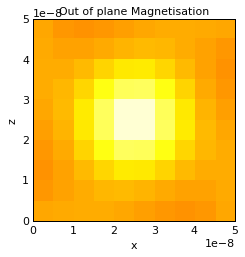

In [9]:
test

We can sample across a holoviews Image element through the centre of the image:

:Layout
   .Image.Out_of_plane_Magnetisation :Image   [x,z]   (My)
   .Curve.I                          :Curve   [x]   (My)
   .Curve.II                         :Curve   [x]   (My)
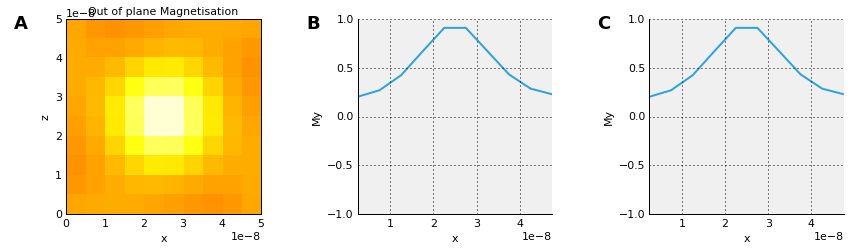

In [10]:
test + test.sample(z = 2.5e-8) + test.sample(z = 2.5e-8)

We might want to change the colourmap of the B image to a divergent colourmap, and add a colorbar. We can do this by setting properties of the renderer with cell magics:


b':Image   [x,z]   (My)'
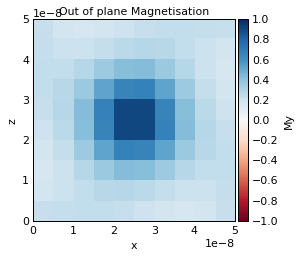

In [11]:
%%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]
test

If we want to set these options permanently, we can do it using the cell magic (note the single '%'):

In [28]:
%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]

We have several dimensions through which to explore the data - the files correspond to different simulation parameters (in this case, the applied field), and we may want to look at how the magnetisation varies along each of the axes. To explore the data, we create a Holomap, which will provide sliders and selectors which allow the varying of how we visualise the simulation data.

The first step to this is to construct dimensions for which we want to explore the data.

In [20]:
physical_dimension = hv.Dimension("SliceDimension")
file = hv.Dimension('File')
slice_dimension = hv.Dimension('Coordinates')

dims = ['x', 'y', 'z']
slicecoords = np.linspace(0, 5e-8, 11)
slicecoords = list(slicecoords)


We now construct the holoviews objects for each combination across parameter space, and show the representation of this as a HoloMap. HoloMaps are created in advance, and can be saved in HTML documents and shared. However, they take up a large amount of memory, and therefore we only create the map for the first 10 files, and only for the 'Mz' dimension.


b':HoloMap   [File,z coordinate]\n   :Image   [x,y]   (Mz)'
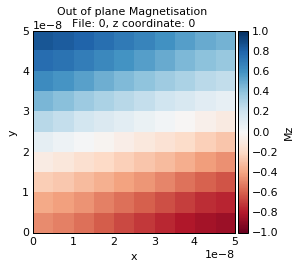
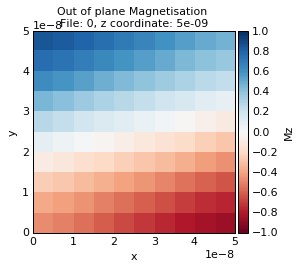
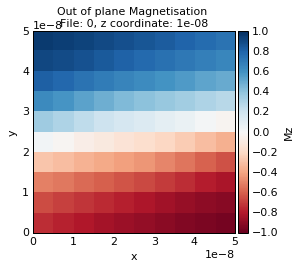
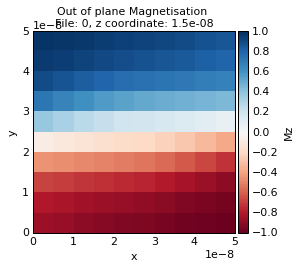
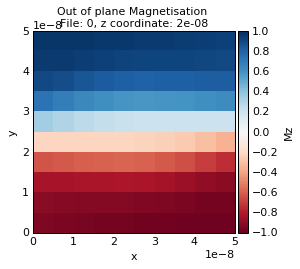
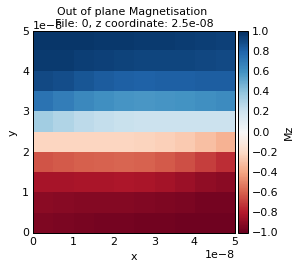
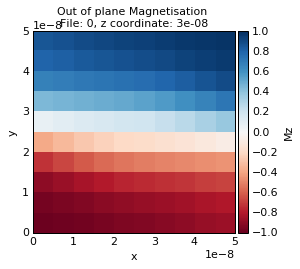
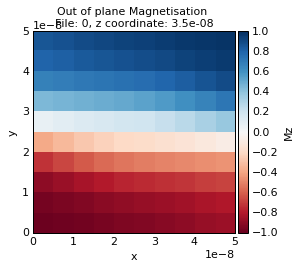
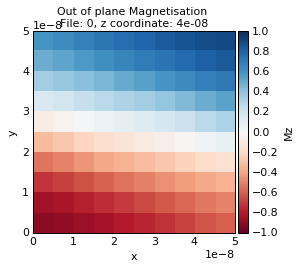
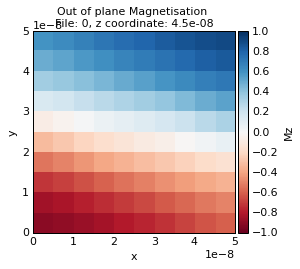
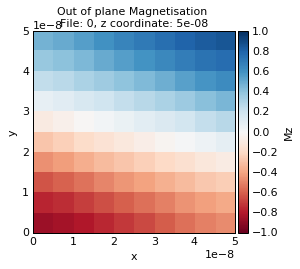
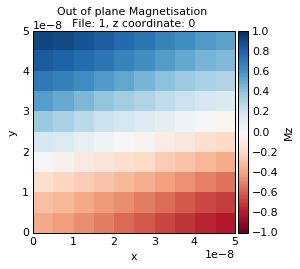
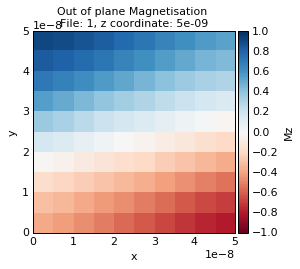
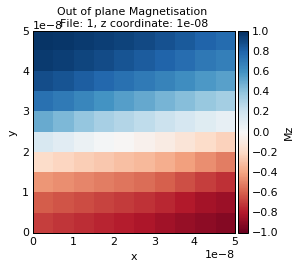
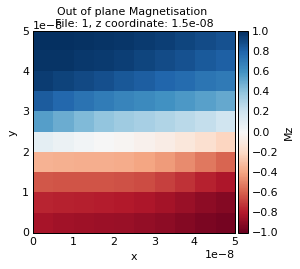
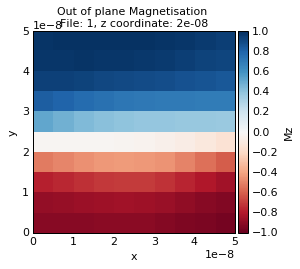
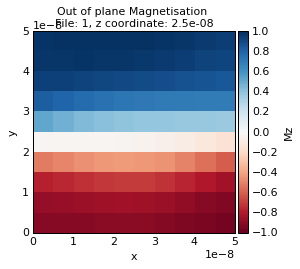
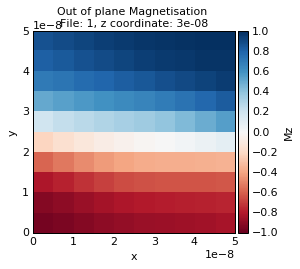
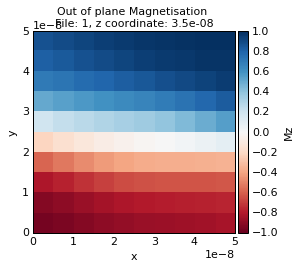
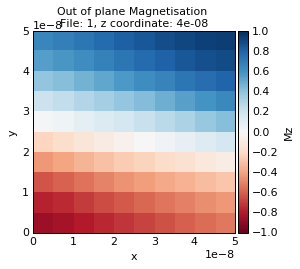
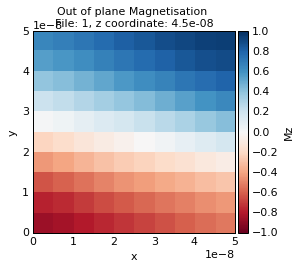
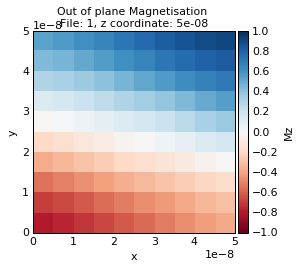
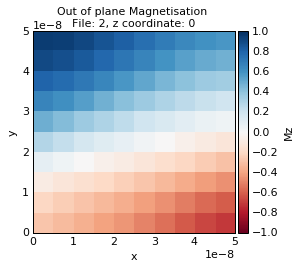
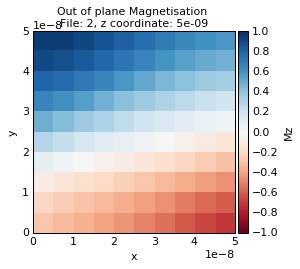
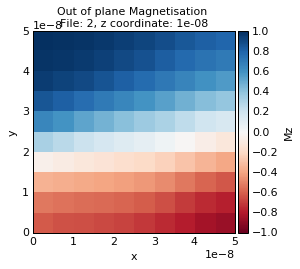
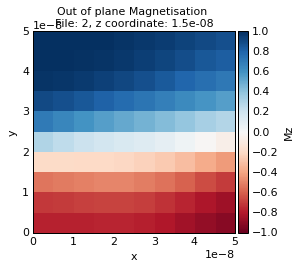
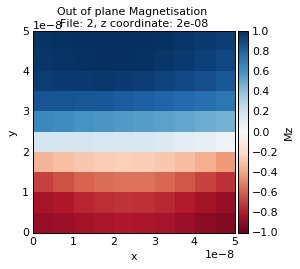
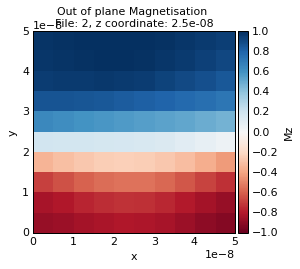
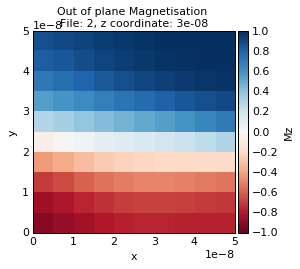
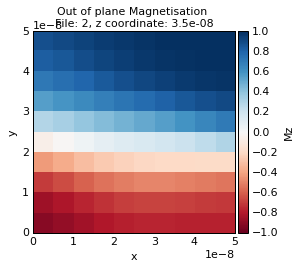
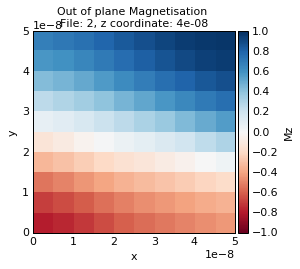
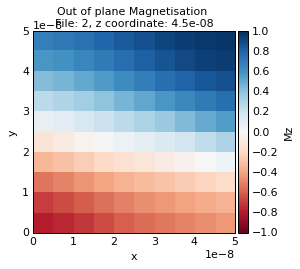
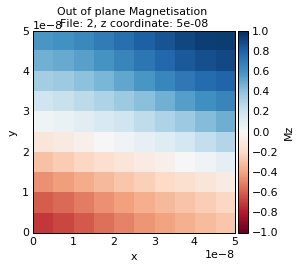
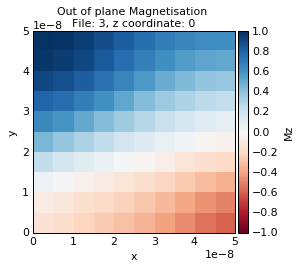
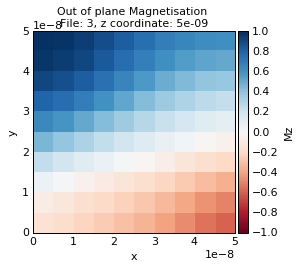
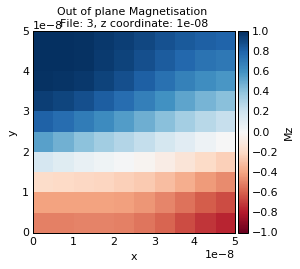
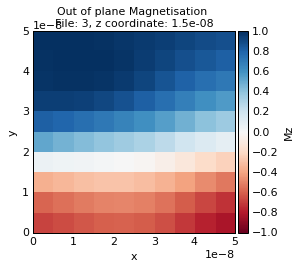
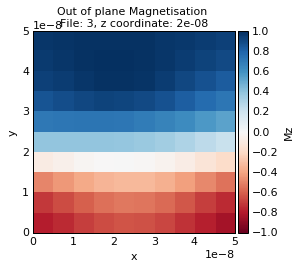
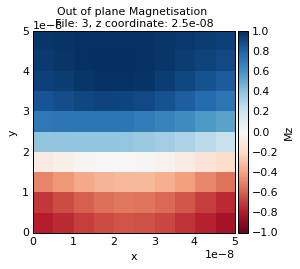
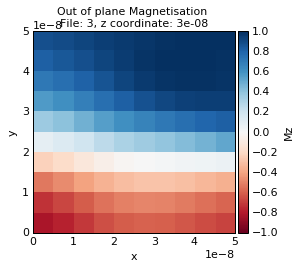
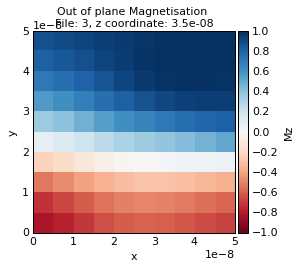
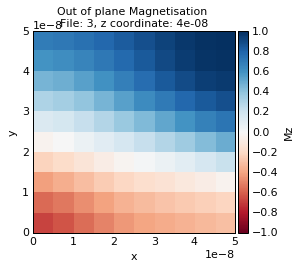
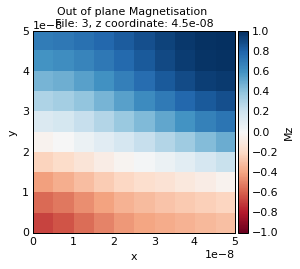
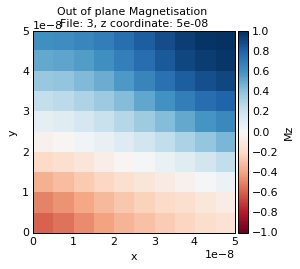
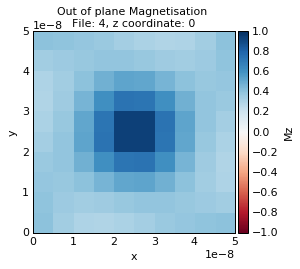
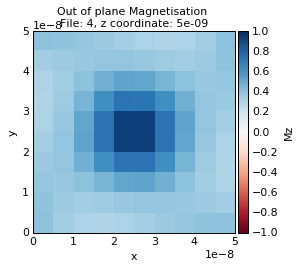
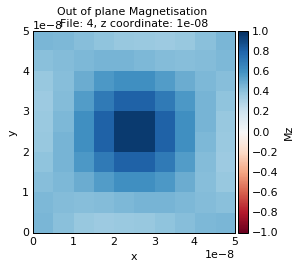
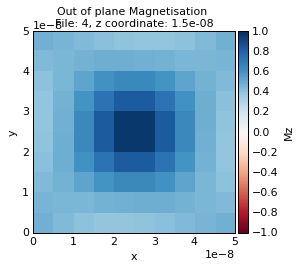
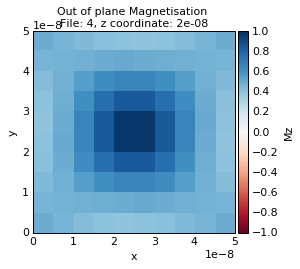
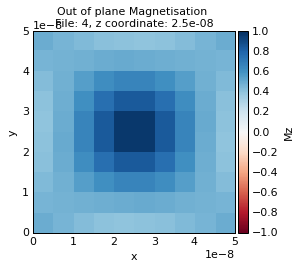
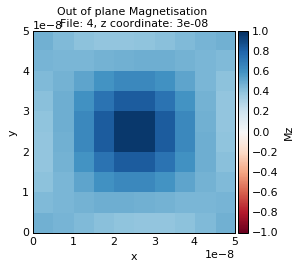
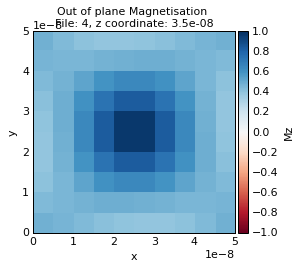
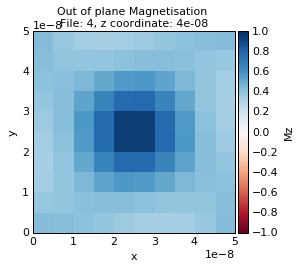
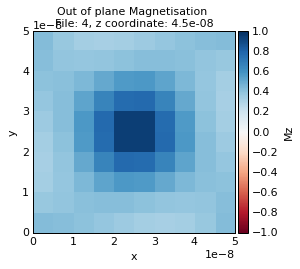
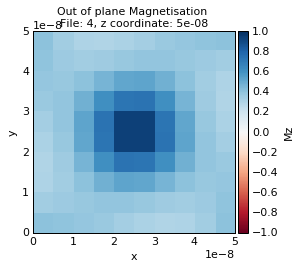
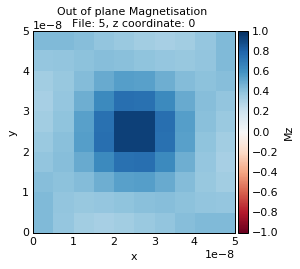
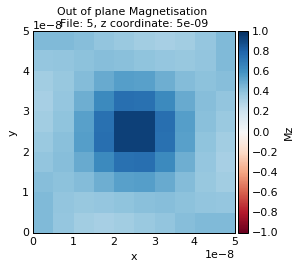
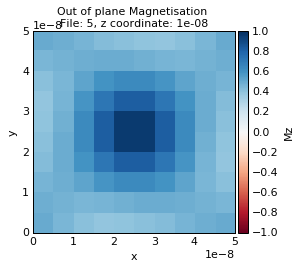
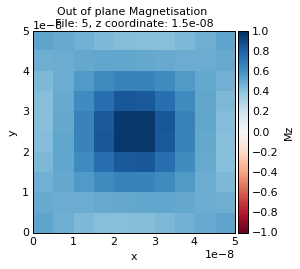
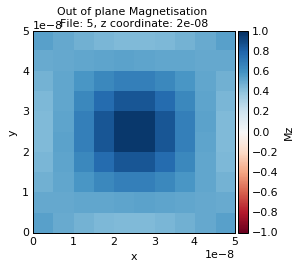
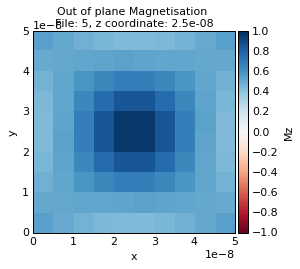
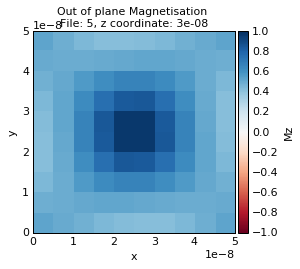
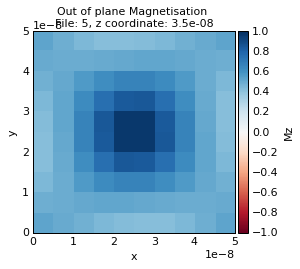
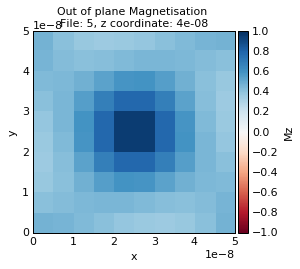
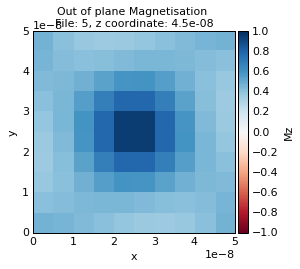
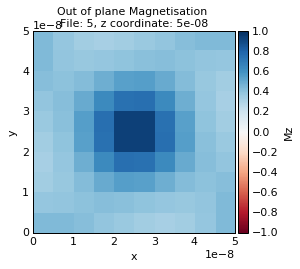
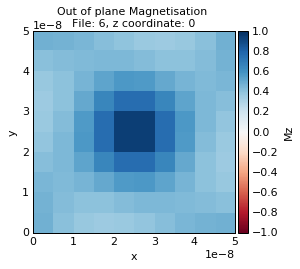
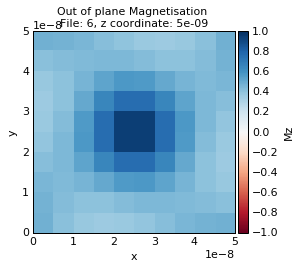
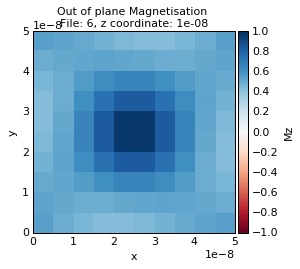
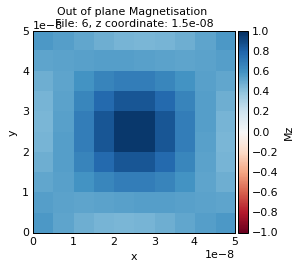
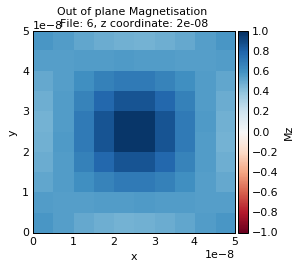
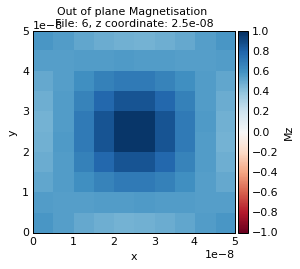
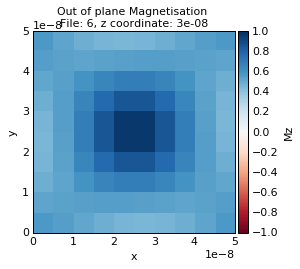
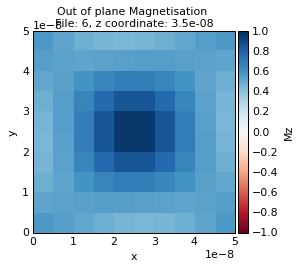
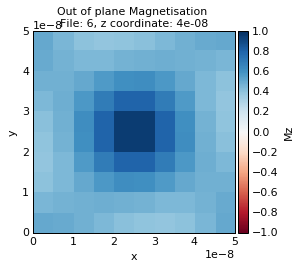
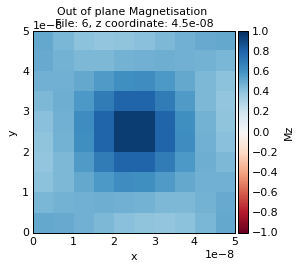
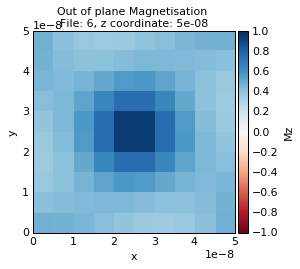
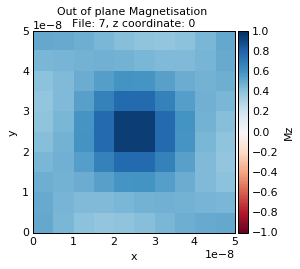
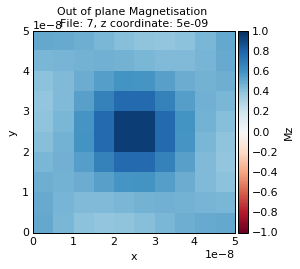
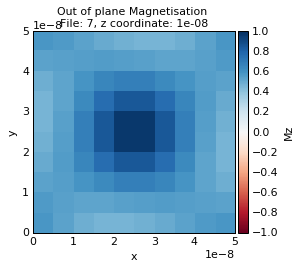
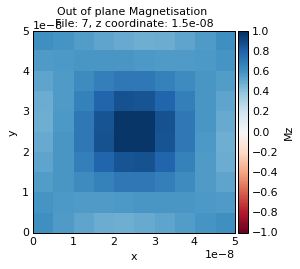
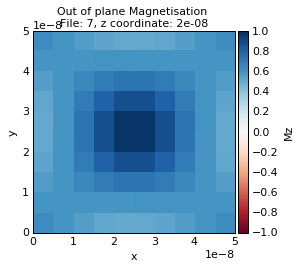
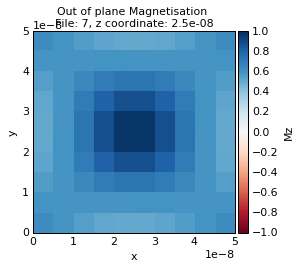
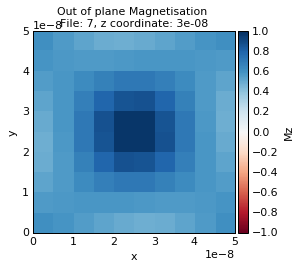
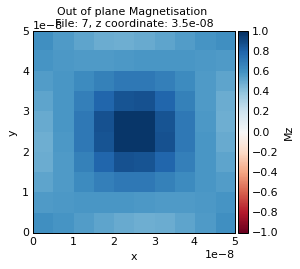
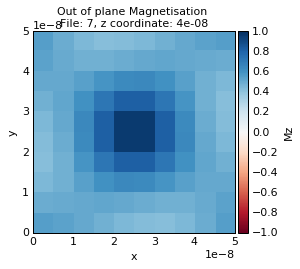
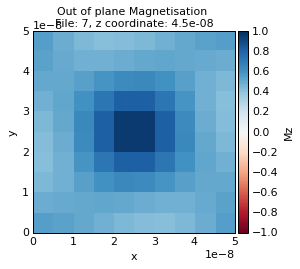
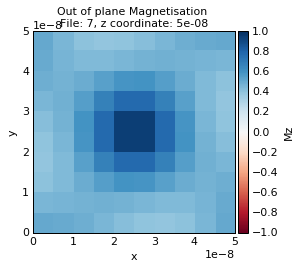
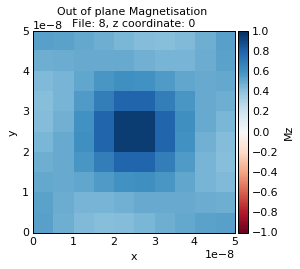
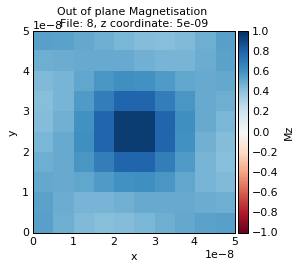
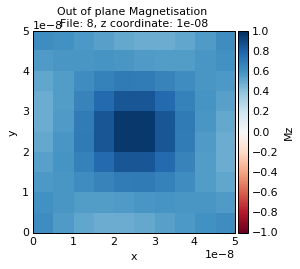
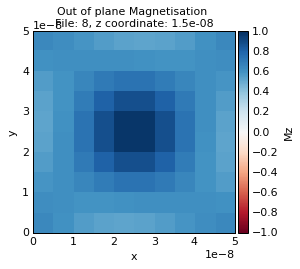
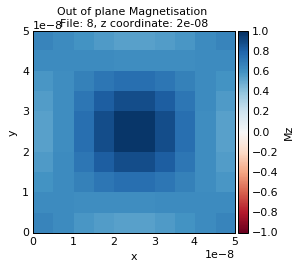
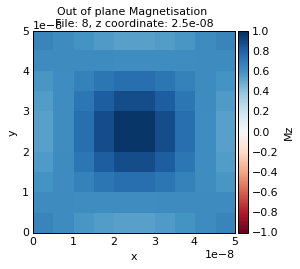
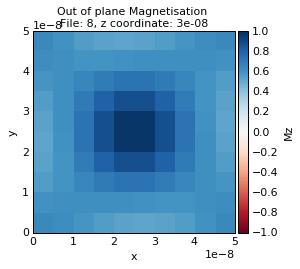
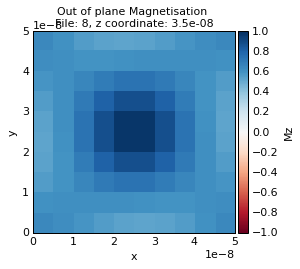
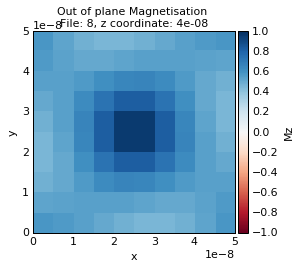
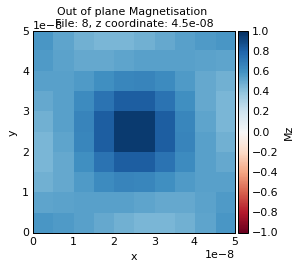
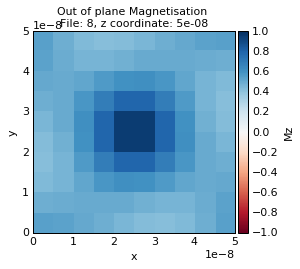
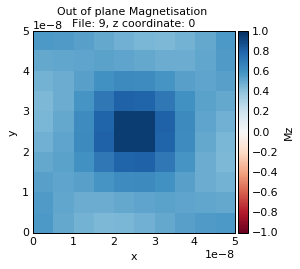
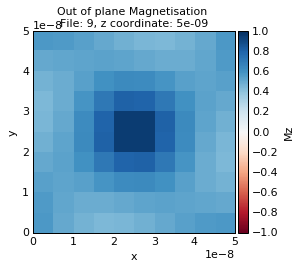
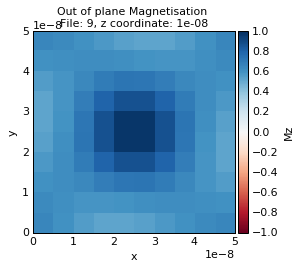
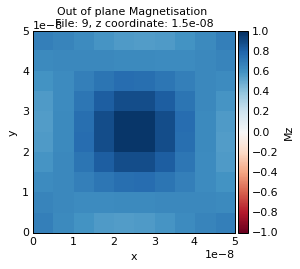
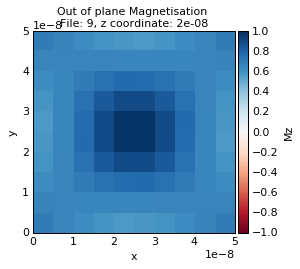
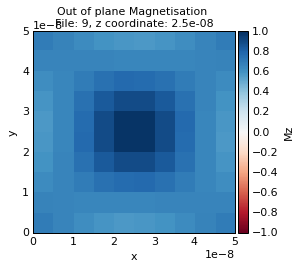
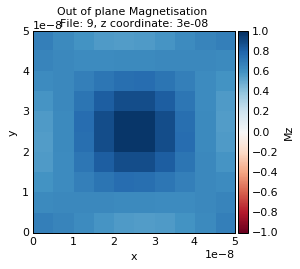
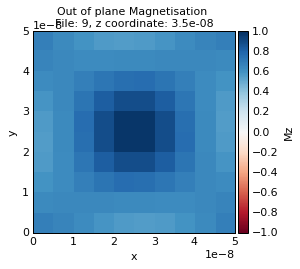
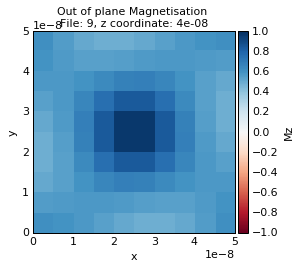
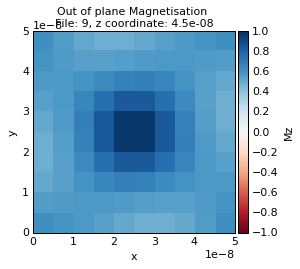
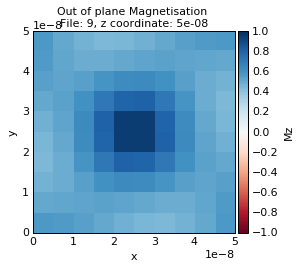

In [29]:
joommftools.create_outofplane_holomap(files[:10], slicecoords, 'z')

Clearly there is a lot of potential. Examples of other parameters you could explore are:
* Time
* System size
* Applied Field
* Exchange/DMI/Anisotropy strength
* Anisotropy Axis

Additionally, other hv objects can be created which can be computed for each slice through the field:
* Field profile along an axis
* Skyrmion number
* Structure factor

Here, we use the same data to create a Dynamic Map - to see this, a live notebook server must be used.

In [35]:
# Here we set the value ranges for the dimensions defined earlier. This 
physical_dimension.values = ['x', 'y', 'z', None]
file.values = files
file.value_format = filename_fun
slice_dimension.values = list(slicecoords)
slice_dimension.values.append(None)

In [33]:
dmap = hv.DynamicMap(joommftools.field2outofplane, kdims=[file, physical_dimension, slice_dimension])

b':DynamicMap   [File,SliceDimension,Coordinates]\n   :Image   [x,y]   (Mz)'
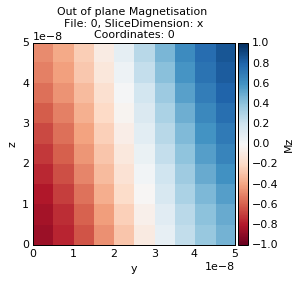

In [36]:
dmap

In [37]:
dmap_inplane = hv.DynamicMap(joommftools.field2inplane, kdims=[file, physical_dimension, slice_dimension])

b':DynamicMap   [File,SliceDimension,Coordinates]\n   :VectorField   [y,z]   (xyfield)'
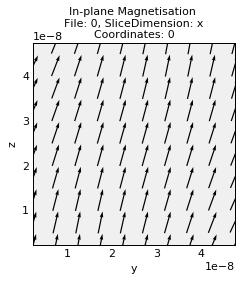

In [38]:
dmap_inplane

:Layout
   .DynamicMap.Out_of_plane_Magnetisation          :DynamicMap   [File,SliceDimension,Coordinates]
      :Image   [x,z]   (My)
   .DynamicMap.In_hyphen_minus_plane_Magnetisation :DynamicMap   [File,SliceDimension,Coordinates]
      :VectorField   [x,y]   (xyfield)
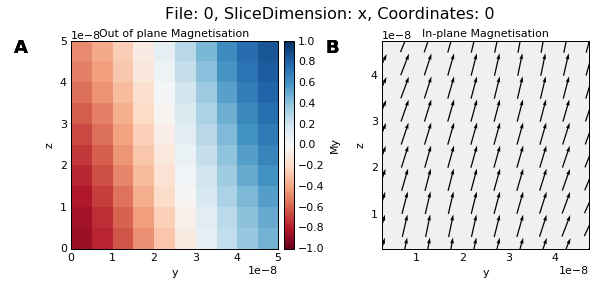

In [39]:
dmap + dmap_inplane 

In [40]:
import pandas as pd

In [21]:
odtpath = os.path.join(datafiles, 'cube_example.odt')

In [22]:
odtdata = oommfodt.OOMMFodt(odtpath)

NameError: name 'oommfodt' is not defined

In [23]:
def odt2df_fromfiles(files, odtfile):
    """
    odt2df_fromfiles(files)
    
    Takes a list of omf filenames and selects rows in ODT file which correspond
    to these files
    
    Inputs
    ------
    files - List of omf file paths
    odtfile - path to OOMMF ODT file. This file must have the columns
        'stage' and 'iteration' as headers, as these are used
        to match up the data. Additionally, OOMMF omf file names must
        not have been modified from their original format.
    """
    strarray = [re.findall(r"[\w']+", file)[10:12] for file in files]
    relevantfiles = np.array([[int(i[0]), int(i[1])] for i in strarray])
    index = pd.DataFrame(relevantfiles, columns = ('stage', 'iteration'))
    
    odtframe = oommfodt.OOMMFodt(odtfile).df
    reduced = pd.merge(index, odtframe)
    reduced = reduced.reset_index()
    return reduced

In [24]:
a = odt2df_fromfiles(files, odtpath)

ValueError: invalid literal for int() with base 10: 'Oxs_MinDriver'

In [25]:
class hvODT:
    def __init__(self, odtpath, omfpaths):
        self.omfpaths = omfpaths
        strarray = [re.findall(r"[\w']+", file)[10:12] for file in omfpaths]
        relevantfiles = np.array([[int(i[0]), int(i[1])] for i in strarray])
        index = pd.DataFrame(relevantfiles, columns = ('stage', 'iteration'))

        odtframe = oommfodt.OOMMFodt(odtpath).df
        reduced = pd.merge(index, odtframe)
        reduced = reduced.reset_index()
        reduced.rename(columns={'index':'File'}, inplace=True)
        self.frame = reduced
        self.headers = list(reduced.columns)[1:]
        self.hv = hv.Table(self.frame)
    def get_curve(self, file, graph):
        if isinstance(file, str):
            try:
                index = self.omfpaths.index(file)
            except:
                raise ValueError("File not in list of OMF files")
        else:
            index = file
        return self.hv.to.curve('File', graph, []) * \
               hv.VLine(index) 

            
odttest = hvODT(odtpath, files)

ValueError: invalid literal for int() with base 10: 'Oxs_MinDriver'

In [26]:
odttest.headers.append(None)

NameError: name 'odttest' is not defined

In [ ]:
graphs = hv.Dimension('Graph', values=odttest.headers)

In [ ]:
dmap_curves = hv.DynamicMap(odttest.get_curve, kdims=[file, graphs])


In [ ]:
kdims

In [ ]:
dmap_curves

In [ ]:
dmap + dmap_inplane + dmap_curves

In [ ]:
dmap_curves

In [ ]:
hv.__version__

In [ ]:
renderer = hv.Store.renderers['matplotlib']

In [17]:
import holoviews as hv
import numpy as np
hv.notebook_extension('matplotlib')
kdims = [file,
         hv.Dimension('SliceDimension', values=['x', 'y', 'z']),
         hv.Dimension('Coordinates', range=(0.01, 1))]
dmap1 = hv.DynamicMap(lambda x, y, z: hv.Image(np.random.rand(10,10)), kdims=kdims)
dmap2 = hv.DynamicMap(lambda x: hv.Curve(np.random.rand(10,2))*hv.VLine(x),
                     kdims=kdims[:1])


In [2]:
import fieldhandler

In [3]:
import glob


In [42]:
file_list = sorted(glob.glob('examples/dynamic_sim/*'))
print(file_list)

['examples/dynamic_sim/cube.mif']


In [6]:
fieldhandler.create_outofplane_dynamic_map?

In [18]:
%%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]
fieldhandler.create_inplane_dynamic_map(file_list, np.linspace(0, 100e-9, 40), 'x')

NameError: name 'fieldhandler' is not defined

In [19]:
np.linspace(0, 100e-9, 80)

array([  0.00000000e+00,   1.26582278e-09,   2.53164557e-09,
         3.79746835e-09,   5.06329114e-09,   6.32911392e-09,
         7.59493671e-09,   8.86075949e-09,   1.01265823e-08,
         1.13924051e-08,   1.26582278e-08,   1.39240506e-08,
         1.51898734e-08,   1.64556962e-08,   1.77215190e-08,
         1.89873418e-08,   2.02531646e-08,   2.15189873e-08,
         2.27848101e-08,   2.40506329e-08,   2.53164557e-08,
         2.65822785e-08,   2.78481013e-08,   2.91139241e-08,
         3.03797468e-08,   3.16455696e-08,   3.29113924e-08,
         3.41772152e-08,   3.54430380e-08,   3.67088608e-08,
         3.79746835e-08,   3.92405063e-08,   4.05063291e-08,
         4.17721519e-08,   4.30379747e-08,   4.43037975e-08,
         4.55696203e-08,   4.68354430e-08,   4.81012658e-08,
         4.93670886e-08,   5.06329114e-08,   5.18987342e-08,
         5.31645570e-08,   5.44303797e-08,   5.56962025e-08,
         5.69620253e-08,   5.82278481e-08,   5.94936709e-08,
         6.07594937e-08,